In [1]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath
from matplotlib.colors import ListedColormap,LinearSegmentedColormap


import pandas as pd
import os

import sys

import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
results_folder = '/rc_scratch/reba1583/XGB_test2_region0/'

results = pd.read_csv(results_folder+'results.csv')
shap_xr = xr.open_dataset(results_folder+'shap.nc')

m = XGBClassifier()
m.load_model(results_folder+'model.json')

In [3]:
m

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [4]:
m.best_iteration

9999

In [5]:
tp = np.where((results.Y_Val==1) & (results.Y_pred==1),1,0).sum()
fp = np.where((results.Y_Val==0) & (results.Y_pred==1),1,0).sum()
tn = np.where((results.Y_Val==0) & (results.Y_pred==0),1,0).sum()
fn = np.where((results.Y_Val==1) & (results.Y_pred==0),1,0).sum()

print('true pos: '+str(np.round(tp/len(results.Y_pred)*100,0))+'%')
print('false pos: '+str(np.round(fp/len(results.Y_pred)*100,0))+'%')
print('true neg: '+str(np.round(tn/len(results.Y_pred)*100,0))+'%')
print('false neg: '+str(np.round(fn/len(results.Y_pred)*100,0))+'%')

print('Accuracy: '+str(np.round(np.where((results.Y_Val== results.Y_pred),1,0).sum()/len(results.Y_pred)*100,0))+'%')

true pos: 10.0%
false pos: 7.0%
true neg: 81.0%
false neg: 3.0%
Accuracy: 90.0%


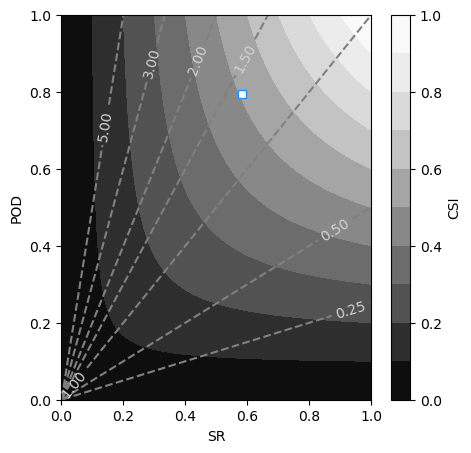

In [6]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/projects/reba1583/Research3/WAF_ML_Tutorial_Part2/scripts/')
#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#calc x,y of performance diagram 
pod= tp/(tp + fn)
sr = tp/(tp + fp)
csi = tp/(tp + fn + fp)

fig,ax = plt.subplots(1,1,figsize=(5,5))

#plot it up  
make_performance_diagram_axis(ax)
ax.plot(sr,pod,'-s',color='dodgerblue',markerfacecolor='w')

## shap summary plots

In [83]:
# # plot individual data points -- skip this cause it's kind of meaningless??
# plot_data_shap = shap_xr.shap_values.stack(data = ['n_channel','lon', 'lat'])
# plot_data_shap_names = plot_data_shap.n_channel.values
# shap.summary_plot(plot_data_shap, feature_names = plot_data_shap_names)


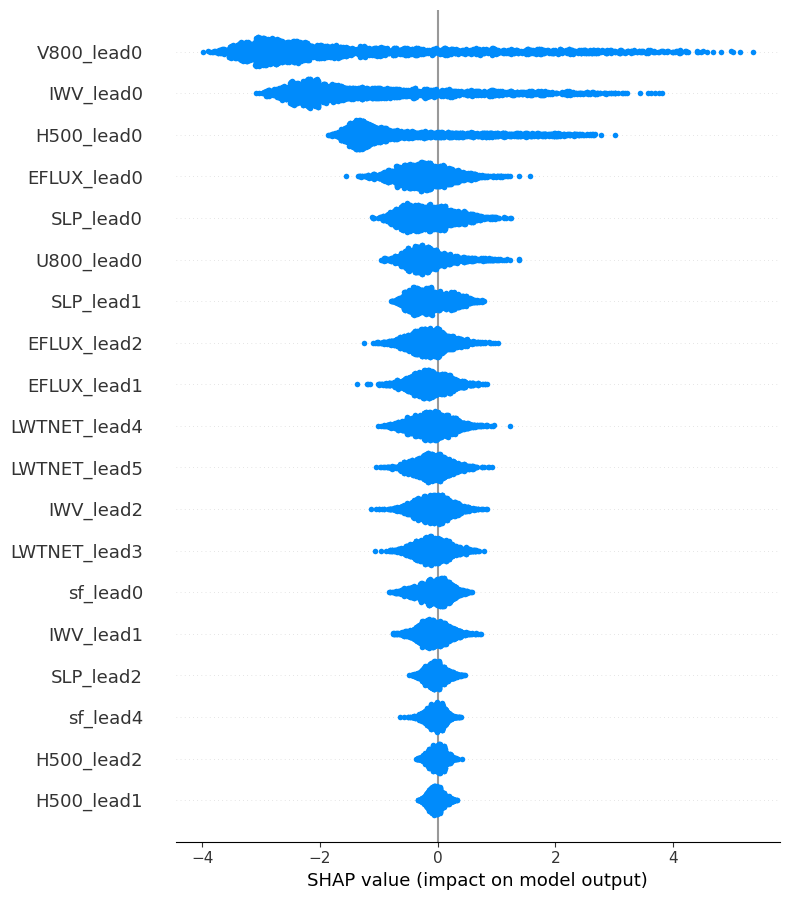

In [7]:
# needs to be shape (categories, time)
plot_data_shap = shap_xr.sum(dim = ['lon','lat']).shap_values.T
plot_data_shap_names = plot_data_shap.n_channel.values
shap.summary_plot(plot_data_shap, feature_names = plot_data_shap_names)


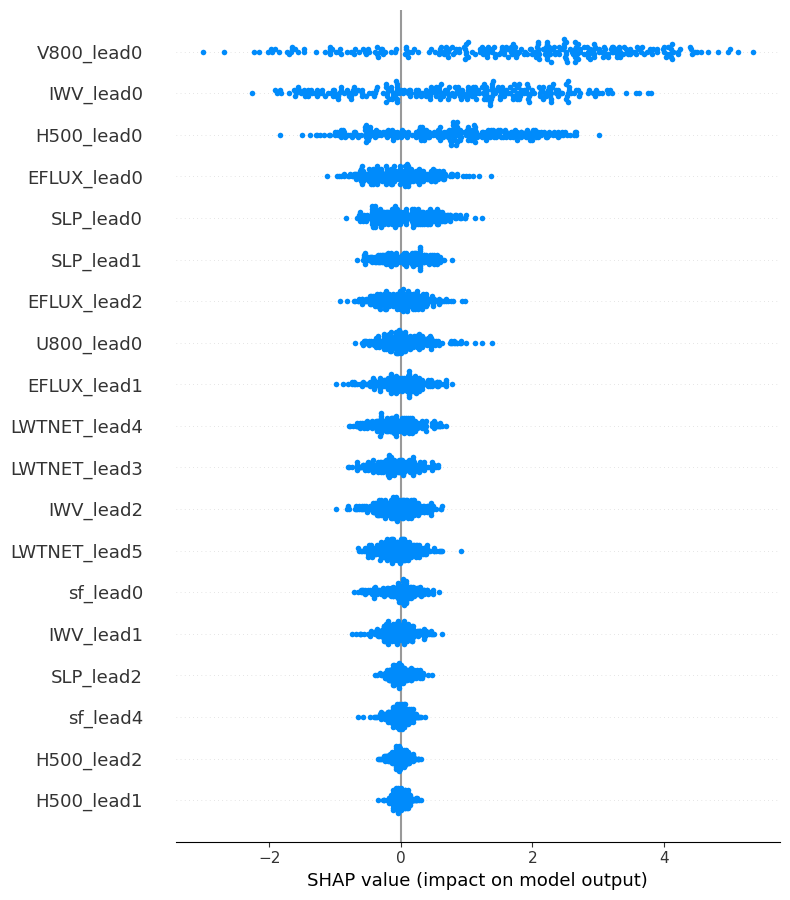

In [8]:
# select where Y_val is 1
plot_data_shap = shap_xr.sel(time = xr.DataArray(pd.to_datetime(results[results.Y_Val ==1].time), dims=["time"])).sum(dim = ('lat','lon')).shap_values.T
plot_data_shap_names = plot_data_shap.n_channel.values
shap.summary_plot(plot_data_shap, feature_names = plot_data_shap_names)


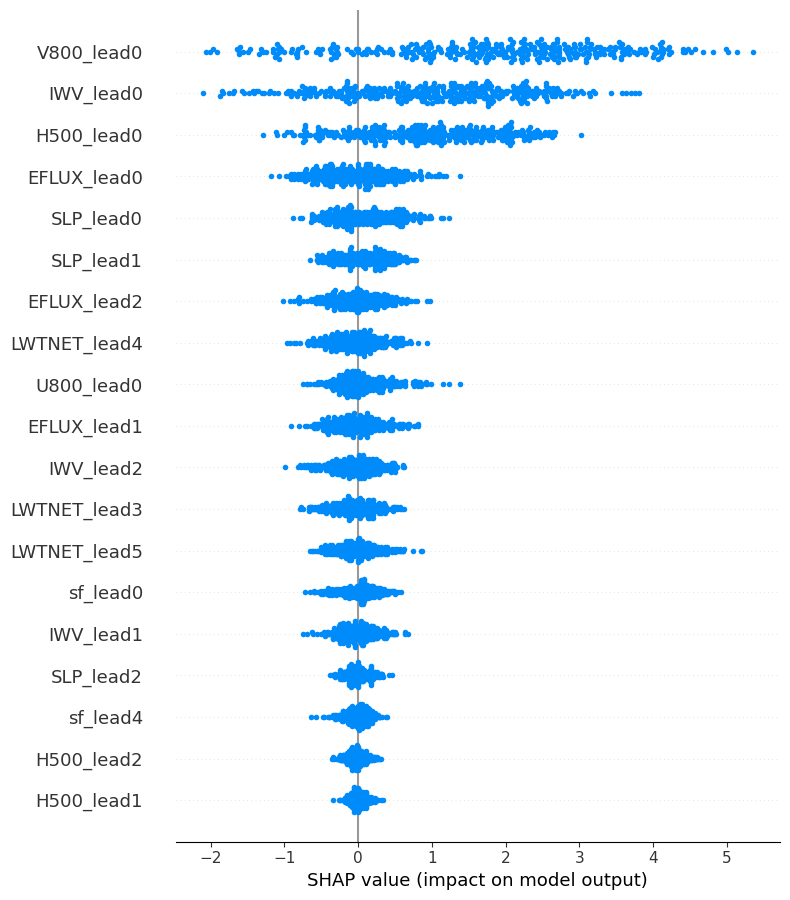

In [9]:
# select where Y_pred is 1
plot_data_shap = shap_xr.sel(time = xr.DataArray(pd.to_datetime(results[results.Y_pred ==1].time), dims=["time"])).sum(dim = ('lat','lon')).shap_values.T
plot_data_shap_names = plot_data_shap.n_channel.values
shap.summary_plot(plot_data_shap, feature_names = plot_data_shap_names)


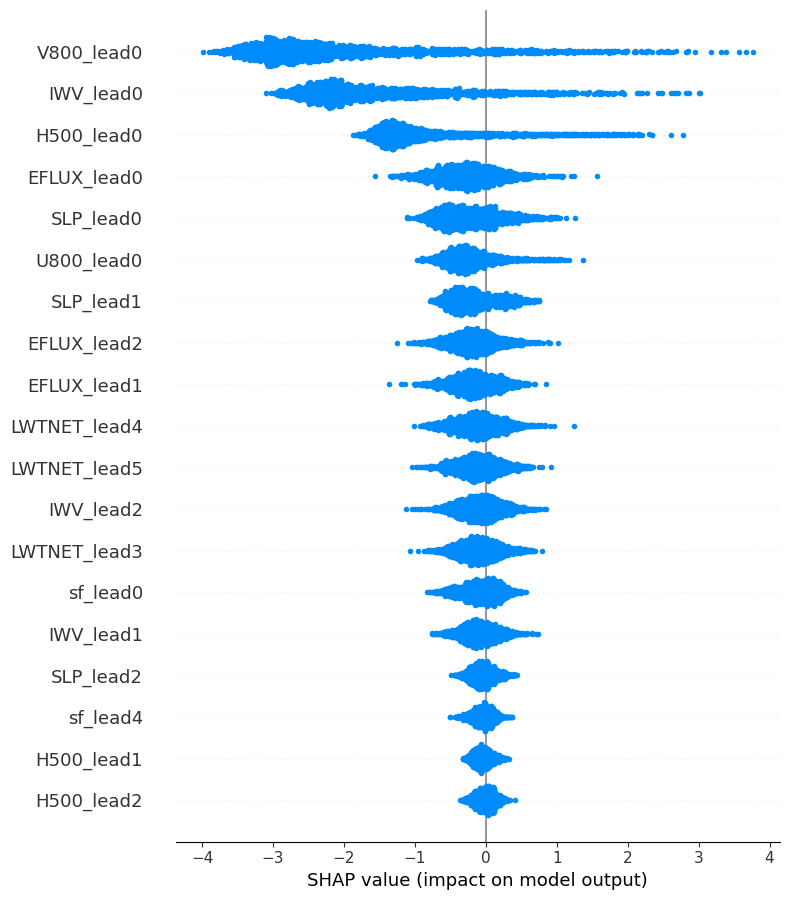

In [10]:
# select where Y_pred is 0
plot_data_shap = shap_xr.sel(time = xr.DataArray(pd.to_datetime(results[results.Y_pred ==0].time), dims=["time"])).sum(dim = ('lat','lon')).shap_values.T
plot_data_shap_names = plot_data_shap.n_channel.values
shap.summary_plot(plot_data_shap, feature_names = plot_data_shap_names)

In [297]:
variable = 'sf_lead0'
one_variable_shap = shap_xr.sel(n_channel = variable).stack(data=['time','lon', 'lat']).shap_values.values
X_ds = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Daily_Data_CNN/validate_full.nc').load()
one_variable_X = X_ds.sel(n_channel = variable).features.stack(data=['time','lon', 'lat']).values
one_variable_X = np.reshape(one_variable_X, (len(one_variable_X),1))
one_variable_shap = np.reshape(one_variable_shap, (len(one_variable_shap),1))


In [294]:
variable

'IWV_lead2'

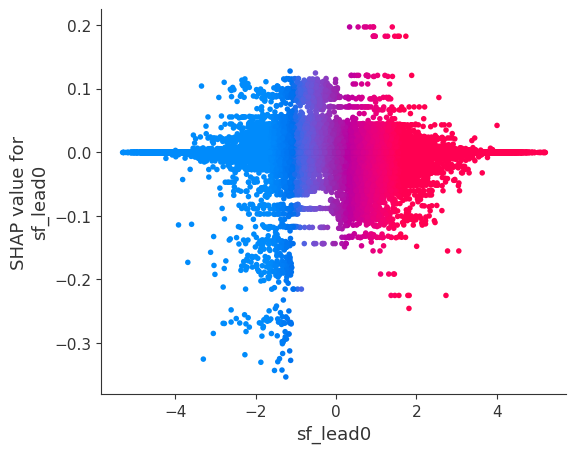

In [300]:




shap.dependence_plot(ind = variable, feature_names = variable, shap_values = one_variable_shap, features = one_variable_X)


## spatial plots

In [11]:
# get spatial information
ds_spatial = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Daily_Data_CNN/train_full.nc').isel(time = 0).load()


In [12]:
# sum over time
plot_data = shap_xr.sum(dim = 'time').shap_values


In [167]:
# absolute values over time
plot_data = np.sum(np.abs(shap_xr.shap_values),1)

In [13]:
# regional mask
focus_region=xr.open_dataset('/projects/reba1583/Research/Data/AIS_Full_basins_Zwally_MERRA2grid.nc')
# focus_region_edit = focus_region.Zwallybasins.where(focus_region.Zwallybasins==0,1)
focus_region_lat = focus_region.sel(lat = slice(-90,-60),lon = slice(0,36)).lat
focus_region_lon = focus_region.sel(lat = slice(-90,-60),lon = slice(0,36)).lon
focus_region_mask = np.ones((len(focus_region_lat),len(focus_region_lon)))


In [14]:
#load maps
ice_shelf_line = cfeature.NaturalEarthFeature('physical', 'antarctic_ice_shelves_lines', '50m',edgecolor='black',facecolor='none') # 10m, 50m, 110m

variable_lats = [
    [-75,-40], [-75,-40], [-75,-40],    
    [-75,-40],    
    [-75,-40],    
    [-75,-40], [-75,-40],[-75,-40],    
    [-75,-20], [-75,-20], [-75,-20],    
    [-20,0], [-20,0], [-20,0],     
    [-90,0], [-90,0],    
    [-75,-40], [-75,-40], [-75,-40],
]

## colors
lightgreen = '#51B3B3'
darkgreen = "#1E4C4C"

lightpink = '#E93788'
darkpink = '#982E59'

lightpurple = '#AB6FF7'
darkpurple = '#520BAF'

lightblue = '#75FBFD'
yellow = '#FADF68'

background = '#F5F3F8'
# create Green
N = 256
green = np.ones((N, 4))
green[:, 0] = np.linspace(30/256, 1, N) # R = 
green[:, 1] = np.linspace(76/256, 1, N) # G =
green[:, 2] = np.linspace(76/256, 1, N)  # B = 
green_cmap = ListedColormap(green).reversed()
green_gradient = np.vstack((np.ones((10,4)), green_cmap(np.linspace(0, 1, 90))))
green_cmap = ListedColormap(green_gradient, name = 'green_cmap')

# create purple
N = 256
purple = np.ones((N, 4))
purple[:, 0] = np.linspace(54/256, 1, N) # R = 
purple[:, 1] = np.linspace(0/256, 1, N) # G =
purple[:, 2] = np.linspace(109/256, 1, N)  # B = 
purple_cmap = ListedColormap(purple).reversed()
purple_gradient = np.vstack((np.ones((10,4)), purple_cmap(np.linspace(0, 1, 90))))
purple_cmap = ListedColormap(purple_gradient, name = 'purple_cmap')


newcolors = np.vstack((green_cmap.reversed()(np.linspace(0, 1, 128)), #(211/256,211/256,211/256,1),
                       purple_cmap.reversed()(np.linspace(1, 0, 128))))
double = ListedColormap(newcolors, name='double')


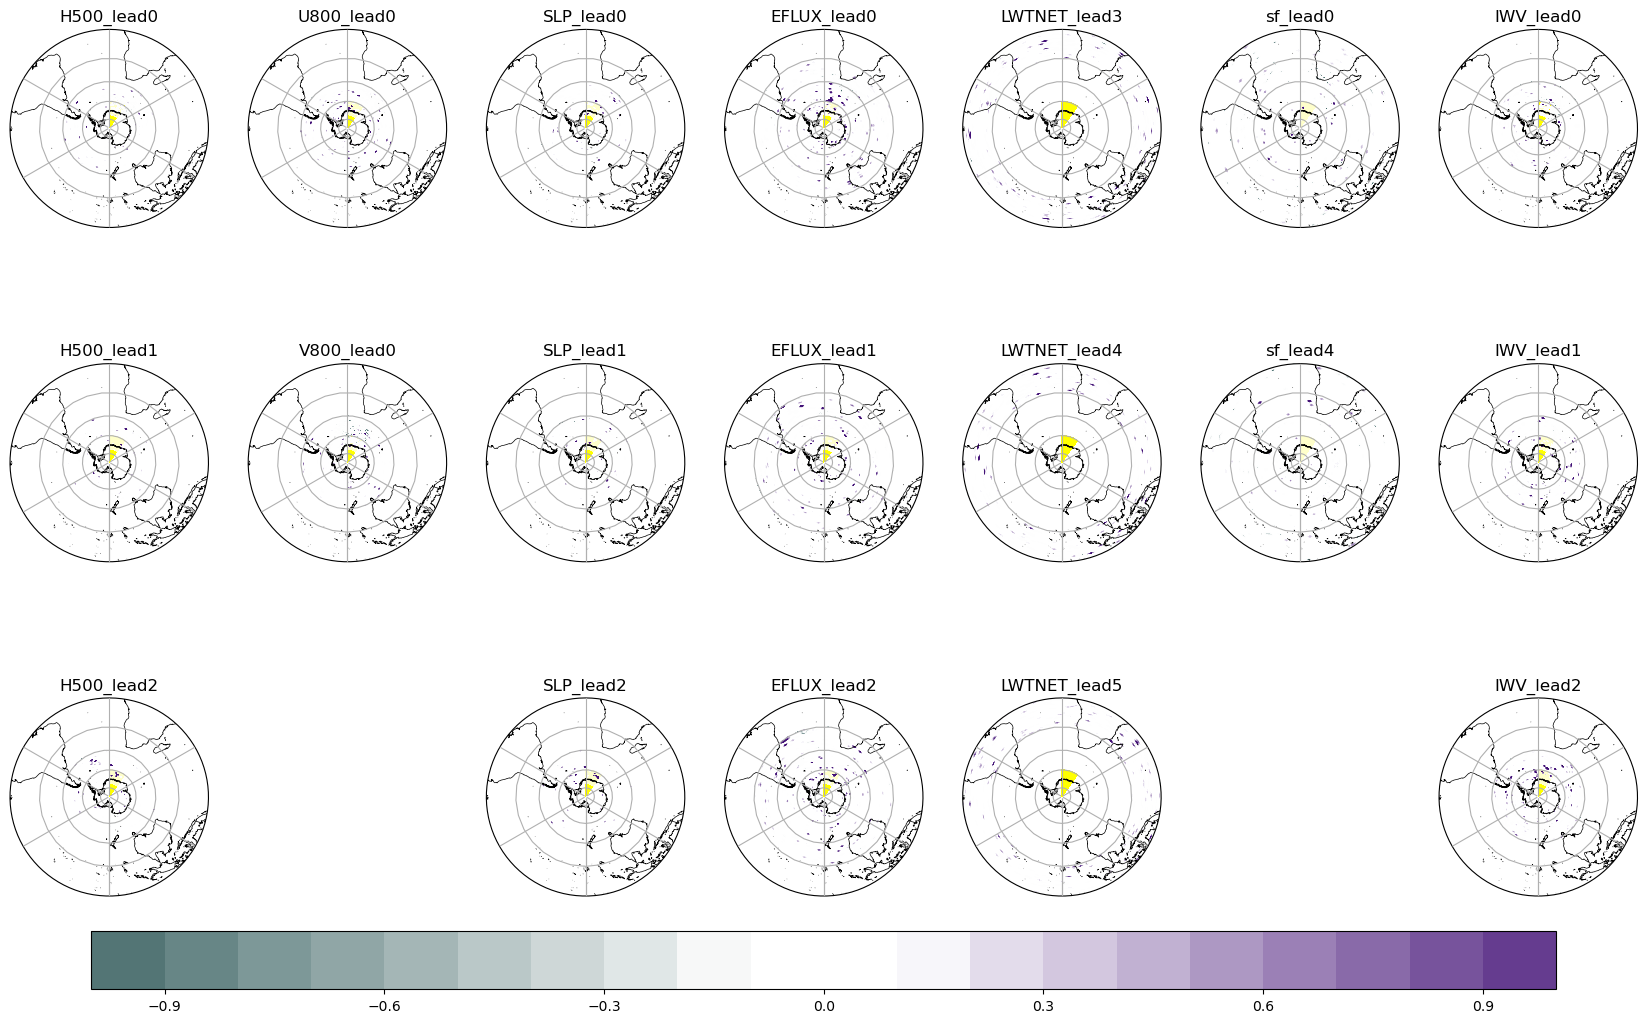

In [15]:
# fig, ax=plt.subplots(ncols=5,nrows=4,figsize=(20,15),subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})
fig = plt.figure(figsize=(21,15), constrained_layout=False)
gs = fig.add_gridspec(3, 7)
ax1 = fig.add_subplot(gs[0, 0], projection =ccrs.SouthPolarStereo(central_longitude=0))
ax2 = fig.add_subplot(gs[1,0], projection =ccrs.SouthPolarStereo(central_longitude=0))
ax3 = fig.add_subplot(gs[2,0], projection =ccrs.SouthPolarStereo(central_longitude=0))

ax4 = fig.add_subplot(gs[0,1 ], projection =ccrs.SouthPolarStereo(central_longitude=0))
ax5 = fig.add_subplot(gs[1,1], projection =ccrs.SouthPolarStereo(central_longitude=0))

ax6 = fig.add_subplot(gs[0, 2], projection =ccrs.SouthPolarStereo(central_longitude=0))
ax7 = fig.add_subplot(gs[1,2], projection =ccrs.SouthPolarStereo(central_longitude=0))
ax8 = fig.add_subplot(gs[2,2], projection =ccrs.SouthPolarStereo(central_longitude=0))

ax9 = fig.add_subplot(gs[0, 3], projection =ccrs.SouthPolarStereo(central_longitude=0))
ax10 = fig.add_subplot(gs[1,3], projection =ccrs.SouthPolarStereo(central_longitude=0))
ax11 = fig.add_subplot(gs[2, 3], projection =ccrs.SouthPolarStereo(central_longitude=0))

ax12 = fig.add_subplot(gs[0,4], projection =ccrs.SouthPolarStereo(central_longitude=0))
ax13 = fig.add_subplot(gs[1,4], projection =ccrs.SouthPolarStereo(central_longitude=0))
ax14 = fig.add_subplot(gs[2,4], projection =ccrs.SouthPolarStereo(central_longitude=0))

ax15 = fig.add_subplot(gs[0, 5], projection =ccrs.SouthPolarStereo(central_longitude=0))
ax16 = fig.add_subplot(gs[1,5], projection =ccrs.SouthPolarStereo(central_longitude=0))

ax17 = fig.add_subplot(gs[0, 6], projection =ccrs.SouthPolarStereo(central_longitude=0))
ax18 = fig.add_subplot(gs[1,6], projection =ccrs.SouthPolarStereo(central_longitude=0))
ax19 = fig.add_subplot(gs[2,6], projection =ccrs.SouthPolarStereo(central_longitude=0))


axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19]
for a in axes:
    a.set_extent([-180, 180, -90, 0], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    a.set_boundary(circle, transform=a.transAxes)
    grid=a.gridlines(zorder = 20)
    grid.n_steps=30
    a.coastlines(resolution='50m', color = 'black',linewidth = .5)
    a.add_feature(ice_shelf_line, color = 'black', linewidth = .5)

    a.contourf(focus_region_lon, focus_region_lat, focus_region_mask,cmap = ListedColormap(['yellow', 'yellow']), transform=ccrs.PlateCarree())
    
for a in range(len(axes)):
    variable = str(plot_data.n_channel[a].values)
    cf = axes[a].contourf(np.linspace(-180,180,144), np.linspace(variable_lats[a][0],variable_lats[a][1],90), 
              plot_data.sel(n_channel = variable).values.T, levels = np.arange(-1,1.1,.1), cmap = double, 
              alpha =.8, transform=ccrs.PlateCarree())
    axes[a].set_title(variable)
cb = plt.colorbar(cf, ax =axes,orientation='horizontal', pad=0.03, extendrect=True, aspect=25, shrink=0.9)
